In [13]:
##############################
# Solves -u'' + u = f        #
# With zero Neumann boundary #
##############################
import radiant as rad
import numpy as np


# Problem Parameters
a = -0.5
b = 0.5


def exact(*x):
    return np.prod(np.cos(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2 + 1) * exact(*x)

In [14]:
# Parameters
d = 1
k = 1
inner = 4
outer = 7
start_delta = 1.5
start_N = 4

# Computed Parameters
ranges = ((a, b),) * d
centre_thinning = 2 ** np.arange(inner)
delta_thinning = 2 ** np.arange(inner)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * start_N)]
deltas = start_delta / delta_thinning

# Integration
integrator = rad.integrate.MeanIntegrator(ranges, 1000)
error_integrator = rad.integrate.QuadIntegrator(ranges)

# Solve for approximate solution
phis = [rad.Wendland(d, k, delta, xc) for delta, xc in zip(deltas, xcs)]
solver = rad.solve.MultilevelSolver(phis, rad.solve.GalerkinSolver, integrator, 'helmholtz', outer=outer)
approx = solver.solve(f)
error = rad.error(exact, approx, error_integrator)

print("L2 Relative Error:", error)
print("Condition Numbers:", solver.cond())

L2 Relative Error: 0.09739111221812896
Condition Numbers: [570.1546690608975, 2171.809364728018, 6034.096201801276, 10242.950215404318]


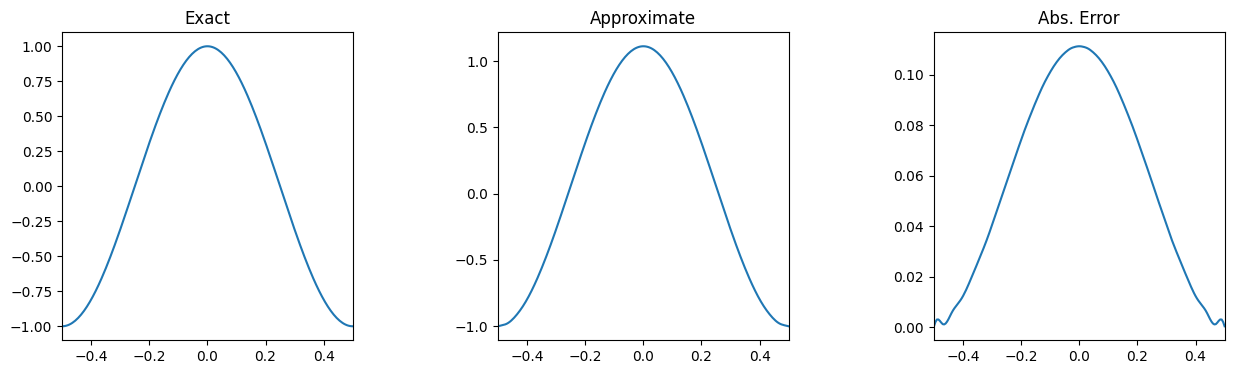

In [15]:
rad.plot.spread(
    ranges,
    exact,
    approx,
    lambda *x: np.abs(exact(*x) - approx(*x)),
    n=200,
    wspace=0.5,
    hspace=0.5,
    titles=["Exact", "Approximate", "Abs. Error"],
    figsize=(15, 4)
)

Once 
 
 Loop 
 
 Reflect

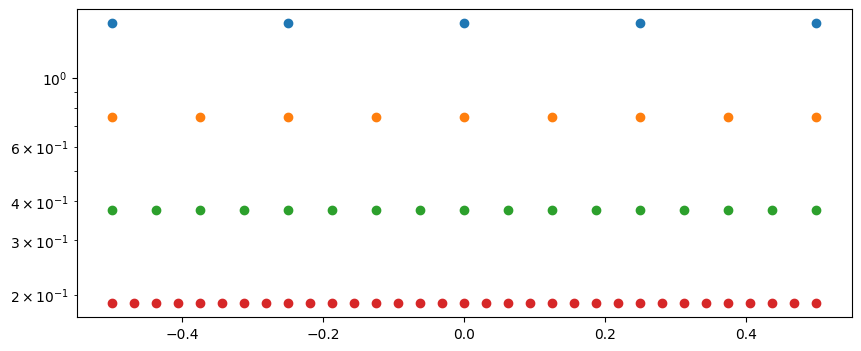

In [16]:
if d == 1:
    from IPython.display import HTML, display_html
    
    
    anim = rad.animate.ml_animate(ranges, exact, approx, n=200, figsize=(10, 4))
    display_html(HTML(anim.to_jshtml()))
    
    rad.plot.thinning(deltas, xcs, d, figsize=(10, 4))